<a href="https://colab.research.google.com/github/Ortimus/GPU-Puzzles/blob/main/GPU_puzzlers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPU Puzzles
- by [Sasha Rush](http://rush-nlp.com) - [srush_nlp](https://twitter.com/srush_nlp)

I recommend doing these in Colab, as it is easy to get started.  Be
sure to make your own copy, turn on GPU mode in the settings (`Runtime / Change runtime type`, then set `Hardware accelerator` to `GPU`), and
then get to coding.

![](https://github.com/srush/GPU-Puzzles/raw/main/cuda.png)

GPU architectures are critical to machine learning, and seem to be
becoming even more important every day. However, you can be an expert
in machine learning without ever touching GPU code. It is hard to gain
intuition working through abstractions.

This notebook is an attempt to teach beginner GPU programming in a
completely interactive fashion. Instead of providing text with
concepts, it throws you right into coding and building GPU
kernels. The exercises use NUMBA which directly maps Python
code to CUDA kernels. It looks like Python but is basically
identical to writing low-level CUDA code.
In a few hours, I think you can go from basics to
understanding the real algorithms that power 99% of deep learning
today. If you do want to read the manual, it is here:

[NUMBA CUDA Guide](https://numba.readthedocs.io/en/stable/cuda/index.html)

(If you are into this style of puzzle, also check out my [Tensor
Puzzles](https://github.com/srush/Tensor-Puzzles) for PyTorch.)

In [1]:
!pip install -qqq git+https://github.com/chalk-diagrams/planar git+https://github.com/danoneata/chalk@srush-patch-1
!wget -q https://github.com/srush/GPU-Puzzles/raw/main/robot.png https://github.com/srush/GPU-Puzzles/raw/main/lib.py

  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!uv pip install -q --system numba-cuda==0.4.0
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

#Also, as an aside, for small examples, you can hide the low occupancy warnings, if desired, by specifying:
config.CUDA_LOW_OCCUPANCY_WARNINGS = 0

In [3]:
import numba
import numpy as np
import warnings
from lib import CudaProblem, Coord

In [4]:
warnings.filterwarnings(
    action="ignore", category=numba.NumbaPerformanceWarning, module="numba"
)

## Puzzle 1: Map

Implement a "kernel" (GPU function) that adds 10 to each position of vector `a`
and stores it in vector `out`.  You have 1 thread per position.

**Warning** This code looks like Python but it is really CUDA! You cannot use
standard python tools like list comprehensions or ask for Numpy properties
like shape or size (if you need the size, it is given as an argument).
The puzzles only require doing simple operations, basically
+, *, simple array indexing, for loops, and if statements.
You are allowed to use local variables.
If you get an
error it is probably because you did something fancy :).

*Tip: Think of the function `call` as being run 1 time for each thread.
The only difference is that `cuda.threadIdx.x` changes each time.*

# Map
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             1 |             1 |             0 |             0 | 



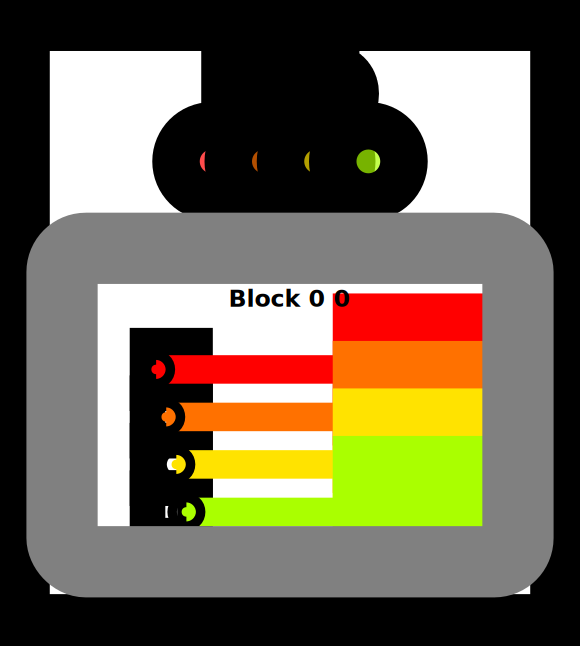

In [5]:
def map_spec(a):
    return a + 10


def map_test(cuda):
    def call(out, a) -> None:
        local_i = cuda.threadIdx.x
        # FILL ME IN (roughly 1 lines)
        out[local_i] = a[local_i] + 10

    return call


SIZE = 4
out = np.zeros((SIZE,))
a = np.arange(SIZE)
problem = CudaProblem(
    "Map", map_test, [a], out, threadsperblock=Coord(SIZE, 1), spec=map_spec
)
problem.show()

In [6]:
problem.check()

Passed Tests!


## Puzzle 2 - Zip

Implement a kernel that adds together each position of `a` and `b` and stores it in `out`.
You have 1 thread per position.

# Zip
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             2 |             1 |             0 |             0 | 



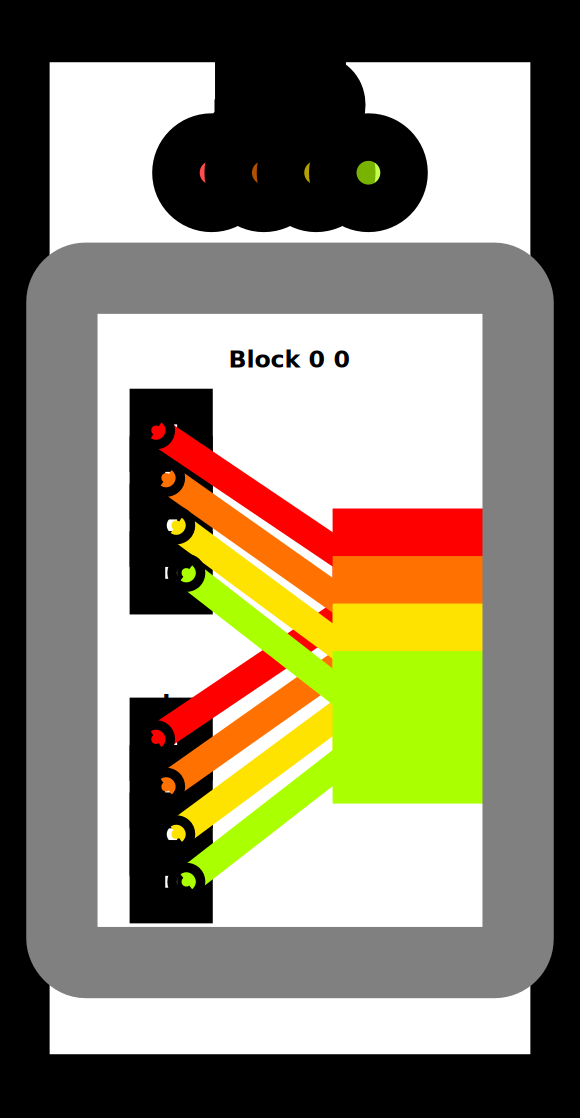

In [7]:
def zip_spec(a, b):
    return a + b


def zip_test(cuda):
    def call(out, a, b) -> None:
        local_i = cuda.threadIdx.x
        # FILL ME IN (roughly 1 lines)
        out[local_i] = a[local_i] + b[local_i]

    return call


SIZE = 4
out = np.zeros((SIZE,))
a = np.arange(SIZE)
b = np.arange(SIZE)
problem = CudaProblem(
    "Zip", zip_test, [a, b], out, threadsperblock=Coord(SIZE, 1), spec=zip_spec
)
problem.show()

In [8]:
problem.check()

Passed Tests!


## Puzzle 3 - Guards

Implement a kernel that adds 10 to each position of `a` and stores it in `out`.
You have more threads than positions.

# Guard
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             1 |             1 |             0 |             0 | 



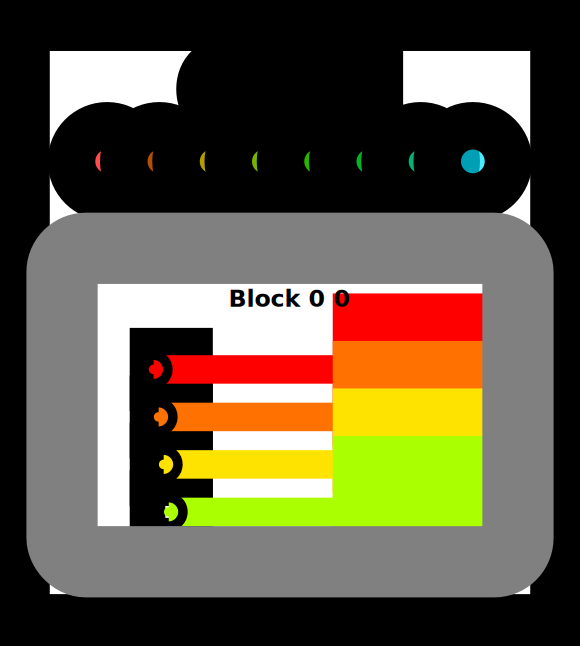

In [10]:
def map_guard_test(cuda):
    def call(out, a, size) -> None:
        local_i = cuda.threadIdx.x
        # FILL ME IN (roughly 2 lines)
        if local_i < size:
          out[local_i] = a[local_i] + 10

    return call


SIZE = 4
out = np.zeros((SIZE,))
a = np.arange(SIZE)
problem = CudaProblem(
    "Guard",
    map_guard_test,
    [a],
    out,
    [SIZE],
    threadsperblock=Coord(8, 1),
    spec=map_spec,
)
problem.show()

In [11]:
problem.check()

Passed Tests!


## Puzzle 4 - Map 2D

Implement a kernel that adds 10 to each position of `a` and stores it in `out`.
Input `a` is 2D and square. You have more threads than positions.

# Map 2D
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             1 |             1 |             0 |             0 | 



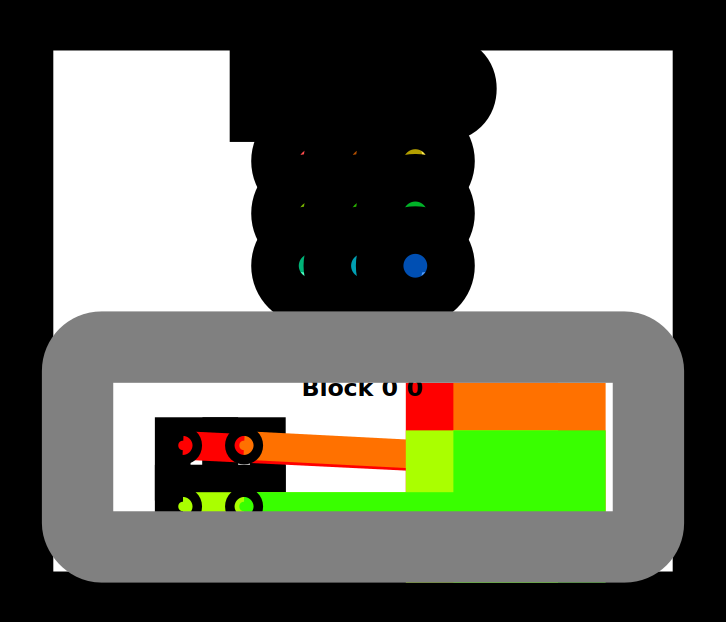

In [13]:
def map_2D_test(cuda):
    def call(out, a, size) -> None:
        local_i = cuda.threadIdx.x
        local_j = cuda.threadIdx.y
        # FILL ME IN (roughly 2 lines)
        if local_i < size and local_j < size:
          out[local_i, local_j] = a[local_i, local_j] + 10

    return call


SIZE = 2
out = np.zeros((SIZE, SIZE))
a = np.arange(SIZE * SIZE).reshape((SIZE, SIZE))
problem = CudaProblem(
    "Map 2D", map_2D_test, [a], out, [SIZE], threadsperblock=Coord(3, 3), spec=map_spec
)
problem.show()

In [14]:
problem.check()

Passed Tests!


## Puzzle 5 - Broadcast

Implement a kernel that adds `a` and `b` and stores it in `out`.
Inputs `a` and `b` are vectors. You have more threads than positions.

# Broadcast
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             0 |             0 |             0 |             0 | 



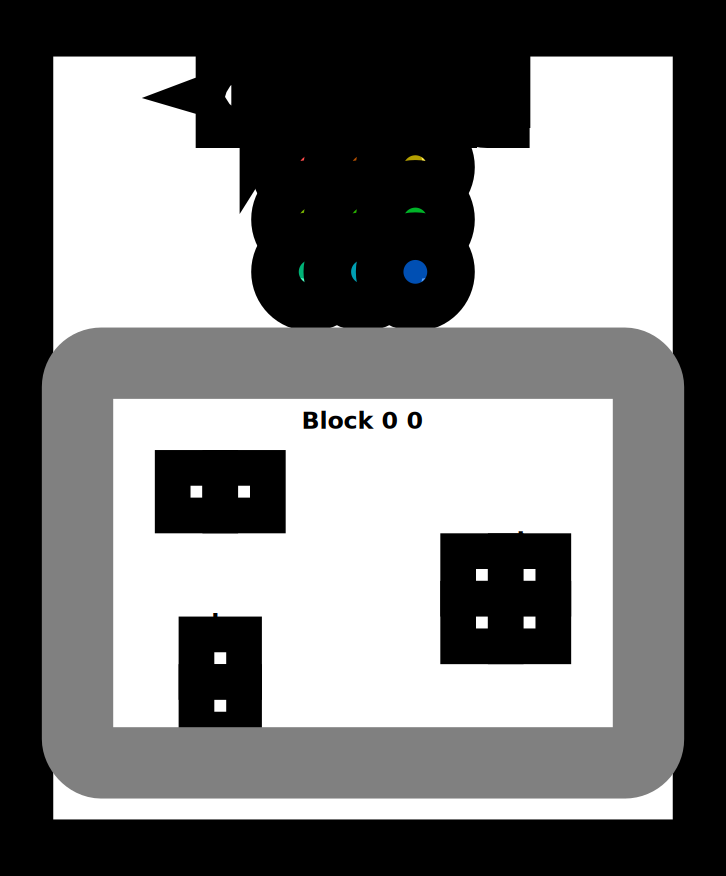

In [15]:
def broadcast_test(cuda):
    def call(out, a, b, size) -> None:
        local_i = cuda.threadIdx.x
        local_j = cuda.threadIdx.y
        # FILL ME IN (roughly 2 lines)

    return call


SIZE = 2
out = np.zeros((SIZE, SIZE))
a = np.arange(SIZE).reshape(SIZE, 1)
b = np.arange(SIZE).reshape(1, SIZE)
problem = CudaProblem(
    "Broadcast",
    broadcast_test,
    [a, b],
    out,
    [SIZE],
    threadsperblock=Coord(3, 3),
    spec=zip_spec,
)
problem.show()

In [ ]:
problem.check()

## Puzzle 6 - Blocks

Implement a kernel that adds 10 to each position of `a` and stores it in `out`.
You have fewer threads per block than the size of `a`.

*Tip: A block is a group of threads. The number of threads per block is limited, but we can
have many different blocks. Variable `cuda.blockIdx` tells us what block we are in.*

In [ ]:
def map_block_test(cuda):
    def call(out, a, size) -> None:
        i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
        # FILL ME IN (roughly 2 lines)

    return call


SIZE = 9
out = np.zeros((SIZE,))
a = np.arange(SIZE)
problem = CudaProblem(
    "Blocks",
    map_block_test,
    [a],
    out,
    [SIZE],
    threadsperblock=Coord(4, 1),
    blockspergrid=Coord(3, 1),
    spec=map_spec,
)
problem.show()

In [ ]:
problem.check()

## Puzzle 7 - Blocks 2D

Implement the same kernel in 2D.  You have fewer threads per block
than the size of `a` in both directions.

In [ ]:
def map_block2D_test(cuda):
    def call(out, a, size) -> None:
        i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
        # FILL ME IN (roughly 4 lines)

    return call


SIZE = 5
out = np.zeros((SIZE, SIZE))
a = np.ones((SIZE, SIZE))

problem = CudaProblem(
    "Blocks 2D",
    map_block2D_test,
    [a],
    out,
    [SIZE],
    threadsperblock=Coord(3, 3),
    blockspergrid=Coord(2, 2),
    spec=map_spec,
)
problem.show()

In [ ]:
problem.check()

## Puzzle 8 - Shared

Implement a kernel that adds 10 to each position of `a` and stores it in `out`.
You have fewer threads per block than the size of `a`.

**Warning**: Each block can only have a *constant* amount of shared
 memory that threads in that block can read and write to. This needs
 to be a literal python constant not a variable. After writing to
 shared memory you need to call `cuda.syncthreads` to ensure that
 threads do not cross.

(This example does not really need shared memory or syncthreads, but it is a demo.)

In [ ]:
TPB = 4
def shared_test(cuda):
    def call(out, a, size) -> None:
        shared = cuda.shared.array(TPB, numba.float32)
        i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
        local_i = cuda.threadIdx.x

        if i < size:
            shared[local_i] = a[i]
            cuda.syncthreads()

        # FILL ME IN (roughly 2 lines)

    return call


SIZE = 8
out = np.zeros(SIZE)
a = np.ones(SIZE)
problem = CudaProblem(
    "Shared",
    shared_test,
    [a],
    out,
    [SIZE],
    threadsperblock=Coord(TPB, 1),
    blockspergrid=Coord(2, 1),
    spec=map_spec,
)
problem.show()

In [ ]:
problem.check()

## Puzzle 9 - Pooling

Implement a kernel that sums together the last 3 position of `a` and stores it in `out`.
You have 1 thread per position. You only need 1 global read and 1 global write per thread.

*Tip: Remember to be careful about syncing.*

In [ ]:
def pool_spec(a):
    out = np.zeros(*a.shape)
    for i in range(a.shape[0]):
        out[i] = a[max(i - 2, 0) : i + 1].sum()
    return out


TPB = 8
def pool_test(cuda):
    def call(out, a, size) -> None:
        shared = cuda.shared.array(TPB, numba.float32)
        i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
        local_i = cuda.threadIdx.x
        # FILL ME IN (roughly 8 lines)

    return call


SIZE = 8
out = np.zeros(SIZE)
a = np.arange(SIZE)
problem = CudaProblem(
    "Pooling",
    pool_test,
    [a],
    out,
    [SIZE],
    threadsperblock=Coord(TPB, 1),
    blockspergrid=Coord(1, 1),
    spec=pool_spec,
)
problem.show()

In [ ]:
problem.check()

## Puzzle 10 - Dot Product

Implement a kernel that computes the dot-product of `a` and `b` and stores it in `out`.
You have 1 thread per position. You only need 2 global reads and 1 global write per thread.

*Note: For this problem you don't need to worry about number of shared reads. We will
 handle that challenge later.*

In [ ]:
def dot_spec(a, b):
    return a @ b

TPB = 8
def dot_test(cuda):
    def call(out, a, b, size) -> None:
        shared = cuda.shared.array(TPB, numba.float32)

        i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
        local_i = cuda.threadIdx.x
        # FILL ME IN (roughly 9 lines)
    return call


SIZE = 8
out = np.zeros(1)
a = np.arange(SIZE)
b = np.arange(SIZE)
problem = CudaProblem(
    "Dot",
    dot_test,
    [a, b],
    out,
    [SIZE],
    threadsperblock=Coord(SIZE, 1),
    blockspergrid=Coord(1, 1),
    spec=dot_spec,
)
problem.show()

In [ ]:
problem.check()

## Puzzle 11 - 1D Convolution

Implement a kernel that computes a 1D convolution between `a` and `b` and stores it in `out`.
You need to handle the general case. You only need 2 global reads and 1 global write per thread.

In [ ]:
def conv_spec(a, b):
    out = np.zeros(*a.shape)
    len = b.shape[0]
    for i in range(a.shape[0]):
        out[i] = sum([a[i + j] * b[j] for j in range(len) if i + j < a.shape[0]])
    return out


MAX_CONV = 4
TPB = 8
TPB_MAX_CONV = TPB + MAX_CONV
def conv_test(cuda):
    def call(out, a, b, a_size, b_size) -> None:
        i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
        local_i = cuda.threadIdx.x

        # FILL ME IN (roughly 17 lines)

    return call


# Test 1

SIZE = 6
CONV = 3
out = np.zeros(SIZE)
a = np.arange(SIZE)
b = np.arange(CONV)
problem = CudaProblem(
    "1D Conv (Simple)",
    conv_test,
    [a, b],
    out,
    [SIZE, CONV],
    Coord(1, 1),
    Coord(TPB, 1),
    spec=conv_spec,
)
problem.show()

In [ ]:
problem.check()

Test 2

In [ ]:
out = np.zeros(15)
a = np.arange(15)
b = np.arange(4)
problem = CudaProblem(
    "1D Conv (Full)",
    conv_test,
    [a, b],
    out,
    [15, 4],
    Coord(2, 1),
    Coord(TPB, 1),
    spec=conv_spec,
)
problem.show()

In [ ]:
problem.check()

## Puzzle 12 - Prefix Sum

Implement a kernel that computes a sum over `a` and stores it in `out`.
If the size of `a` is greater than the block size, only store the sum of
each block.

We will do this using the [parallel prefix sum](https://en.wikipedia.org/wiki/Prefix_sum) algorithm in shared memory.
That is, each step of the algorithm should sum together half the remaining numbers.
Follow this diagram:

![](https://user-images.githubusercontent.com/35882/178757889-1c269623-93af-4a2e-a7e9-22cd55a42e38.png)

In [ ]:
TPB = 8
def sum_spec(a):
    out = np.zeros((a.shape[0] + TPB - 1) // TPB)
    for j, i in enumerate(range(0, a.shape[-1], TPB)):
        out[j] = a[i : i + TPB].sum()
    return out


def sum_test(cuda):
    def call(out, a, size: int) -> None:
        cache = cuda.shared.array(TPB, numba.float32)
        i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
        local_i = cuda.threadIdx.x
        # FILL ME IN (roughly 12 lines)

    return call


# Test 1

SIZE = 8
out = np.zeros(1)
inp = np.arange(SIZE)
problem = CudaProblem(
    "Sum (Simple)",
    sum_test,
    [inp],
    out,
    [SIZE],
    Coord(1, 1),
    Coord(TPB, 1),
    spec=sum_spec,
)
problem.show()

In [ ]:
problem.check()

Test 2

In [ ]:
SIZE = 15
out = np.zeros(2)
inp = np.arange(SIZE)
problem = CudaProblem(
    "Sum (Full)",
    sum_test,
    [inp],
    out,
    [SIZE],
    Coord(2, 1),
    Coord(TPB, 1),
    spec=sum_spec,
)
problem.show()

In [ ]:
problem.check()

## Puzzle 13 - Axis Sum

Implement a kernel that computes a sum over each column of `a` and stores it in `out`.

In [ ]:
TPB = 8
def sum_spec(a):
    out = np.zeros((a.shape[0], (a.shape[1] + TPB - 1) // TPB))
    for j, i in enumerate(range(0, a.shape[-1], TPB)):
        out[..., j] = a[..., i : i + TPB].sum(-1)
    return out


def axis_sum_test(cuda):
    def call(out, a, size: int) -> None:
        cache = cuda.shared.array(TPB, numba.float32)
        i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
        local_i = cuda.threadIdx.x
        batch = cuda.blockIdx.y
        # FILL ME IN (roughly 12 lines)

    return call


BATCH = 4
SIZE = 6
out = np.zeros((BATCH, 1))
inp = np.arange(BATCH * SIZE).reshape((BATCH, SIZE))
problem = CudaProblem(
    "Axis Sum",
    axis_sum_test,
    [inp],
    out,
    [SIZE],
    Coord(1, BATCH),
    Coord(TPB, 1),
    spec=sum_spec,
)
problem.show()

In [ ]:
problem.check()

## Puzzle 14 - Matrix Multiply!

Implement a kernel that multiplies square matrices `a` and `b` and
stores the result in `out`.

*Tip: The most efficient algorithm here will copy a block into
 shared memory before computing each of the individual row-column
 dot products. This is easy to do if the matrix fits in shared
 memory.  Do that case first. Then update your code to compute
 a partial dot-product and iteratively move the part you
 copied into shared memory.* You should be able to do the hard case
 in 6 global reads.

In [ ]:
def matmul_spec(a, b):
    return a @ b


TPB = 3
def mm_oneblock_test(cuda):
    def call(out, a, b, size: int) -> None:
        a_shared = cuda.shared.array((TPB, TPB), numba.float32)
        b_shared = cuda.shared.array((TPB, TPB), numba.float32)

        i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
        j = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
        local_i = cuda.threadIdx.x
        local_j = cuda.threadIdx.y
        # FILL ME IN (roughly 14 lines)

    return call

# Test 1

SIZE = 2
out = np.zeros((SIZE, SIZE))
inp1 = np.arange(SIZE * SIZE).reshape((SIZE, SIZE))
inp2 = np.arange(SIZE * SIZE).reshape((SIZE, SIZE)).T

problem = CudaProblem(
    "Matmul (Simple)",
    mm_oneblock_test,
    [inp1, inp2],
    out,
    [SIZE],
    Coord(1, 1),
    Coord(TPB, TPB),
    spec=matmul_spec,
)
problem.show(sparse=True)

In [ ]:
problem.check()

Test 2

In [ ]:
SIZE = 8
out = np.zeros((SIZE, SIZE))
inp1 = np.arange(SIZE * SIZE).reshape((SIZE, SIZE))
inp2 = np.arange(SIZE * SIZE).reshape((SIZE, SIZE)).T

problem = CudaProblem(
    "Matmul (Full)",
    mm_oneblock_test,
    [inp1, inp2],
    out,
    [SIZE],
    Coord(3, 3),
    Coord(TPB, TPB),
    spec=matmul_spec,
)
problem.show(sparse=True)

In [ ]:
problem.check()